# Personalized Restaurant Recommendation (Improved - No Data Leakage)

**Task.** Given a user `u` and an unseen restaurant `i`, predict a personalized recommendation score $\hat{r}_{u,i}$ (used for ranking). We evaluate rating prediction with **RMSE** and **MAE**.

**Key Improvements over `baseline.ipynb`:**
- **Fixed data leakage**: Removed use of current `review_text` which wouldn't be available at prediction time
- **Proper user features**: Extract user preferences from `history_reviews` (past reviews)
- **Sentiment analysis**: Added sentiment features from historical reviews

**Dataset.** Google Restaurants — dataset of restaurants from Google Local (Google Maps).

## 1. Data Loading and Preprocessing

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from textblob import TextBlob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from gensim.models import Word2Vec
import re
import random
import os


# Load data
with open("filter_all_t.json", "r") as f:
    data = json.load(f)

train_df = pd.DataFrame(data["train"])
val_df = pd.DataFrame(data.get("val", []))
test_df = pd.DataFrame(data.get("test", []))

# Remove pics column to save memory
train_df = train_df.drop(columns=["pics"], errors="ignore")
val_df = val_df.drop(columns=["pics"], errors="ignore")
test_df = test_df.drop(columns=["pics"], errors="ignore")

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

ModuleNotFoundError: No module named 'textblob'

In [3]:
train_df.head()

,business_id,user_id,rating,review_text,history_reviews
0,60567465d335d0abfb415b26,101074926318992653684,4,The tang of the tomato sauce is outstanding. A...,[[101074926318992653684_6056272797d555cc6fb0d1...
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5,Chicken and waffles were really good!,[[117065749986299237881_605206f8d8c08f462b93e8...
2,604be10877e81aaed3cc9a1e,106700937793048450809,4,The appetizer of colossal shrimp was very good...,[[106700937793048450809_6044300b27f39b7b5d1dbf...
3,60411e017cd8bf130362365a,101643045857250355161,5,The fish tacos here omg! The salad was great ...,[[101643045857250355161_604fbdd099686c10168c91...
4,604139dd7cd8bf1303624208,109802745326785766951,4,"Ribs are great, as are the mac and cheese, fri...",[[109802745326785766951_60524fa9f09a4ffff042f9...


## 2. Feature Engineering (No Leakage)

### Legitimate Features:
- `user_avg`, `item_avg`: Average ratings from **training data only**
- `user_count`, `item_count`: Activity counts from **training data only**
- `history_reviews`: User's **past reviews** (available at prediction time)

### Removed (Data Leakage):
- ~~`review_text`~~: Current review text (not available at prediction time)
- ~~`review_len`~~: Length of current review

In [4]:
# Compute training statistics (used for all models)
user_avg = train_df.groupby("user_id")["rating"].mean()
item_avg = train_df.groupby("business_id")["rating"].mean()
user_count = train_df.groupby("user_id").size()
item_count = train_df.groupby("business_id").size()
global_mean = train_df["rating"].mean()

print(f"Global mean rating: {global_mean:.3f}")
print(f"Unique users in train: {len(user_avg)}")
print(f"Unique items in train: {len(item_avg)}")

Global mean rating: 4.465
Unique users in train: 29596
Unique items in train: 27896


In [5]:
def extract_history_features(history_reviews):
    """Extract features from user's historical reviews (NO LEAKAGE).
    
    Args:
        history_reviews: List of [review_id, review_text] pairs
    
    Returns:
        Dictionary of features extracted from historical reviews
    """
    # Parse historical review texts
    hist_texts = []
    if history_reviews:
        for h in history_reviews:
            if len(h) >= 2 and h[1]:
                hist_texts.append(h[1])
    
    if not hist_texts:
        return {
            'hist_count': 0,
            'hist_avg_len': 0,
            'hist_avg_polarity': 0,
            'hist_avg_subjectivity': 0,
            'hist_combined_text': ""
        }
    
    # Text statistics
    avg_len = np.mean([len(t) for t in hist_texts])
    
    # Sentiment analysis
    polarities = []
    subjectivities = []
    for text in hist_texts:
        try:
            blob = TextBlob(text)
            polarities.append(blob.sentiment.polarity)
            subjectivities.append(blob.sentiment.subjectivity)
        except:
            pass
    
    avg_polarity = np.mean(polarities) if polarities else 0
    avg_subjectivity = np.mean(subjectivities) if subjectivities else 0
    
    return {
        'hist_count': len(hist_texts),
        'hist_avg_len': avg_len,
        'hist_avg_polarity': avg_polarity,
        'hist_avg_subjectivity': avg_subjectivity,
        'hist_combined_text': " ".join(hist_texts)
    }

In [6]:
def add_features(df, user_avg, item_avg, user_count, item_count, global_mean):
    """Add legitimate features without data leakage."""
    df = df.copy()
    
    # User/item statistics from training (legitimate)
    df["user_avg"] = df["user_id"].map(user_avg).fillna(global_mean)
    df["item_avg"] = df["business_id"].map(item_avg).fillna(global_mean)
    df["user_count"] = df["user_id"].map(user_count).fillna(0)
    df["item_count"] = df["business_id"].map(item_count).fillna(0)
    
    # Extract history features with sentiment
    print("Extracting history features with sentiment analysis...")
    hist_features = df["history_reviews"].apply(extract_history_features)
    hist_df = pd.DataFrame(hist_features.tolist())
    
    df["hist_count"] = hist_df["hist_count"].values
    df["hist_avg_len"] = hist_df["hist_avg_len"].values
    df["hist_avg_polarity"] = hist_df["hist_avg_polarity"].values
    df["hist_avg_subjectivity"] = hist_df["hist_avg_subjectivity"].values
    df["hist_combined_text"] = hist_df["hist_combined_text"].values
    
    return df

# Apply features to all splits
train_df = add_features(train_df, user_avg, item_avg, user_count, item_count, global_mean)
val_df = add_features(val_df, user_avg, item_avg, user_count, item_count, global_mean)
test_df = add_features(test_df, user_avg, item_avg, user_count, item_count, global_mean)

Extracting history features with sentiment analysis...
Extracting history features with sentiment analysis...
Extracting history features with sentiment analysis...


In [7]:
# Verify features
print("Features added:")
print(train_df[["user_avg", "item_avg", "hist_count", "hist_avg_polarity", "hist_avg_subjectivity"]].describe())

Features added:
           user_avg      item_avg    hist_count  hist_avg_polarity  \
count  87013.000000  87013.000000  87013.000000       87013.000000   
mean       4.465252      4.465252      3.399825           0.334748   
std        0.576529      0.529461      4.476290           0.284386   
min        1.000000      1.000000      0.000000          -1.000000   
25%        4.100000      4.260870      1.000000           0.160000   
50%        4.500000      4.555556      2.000000           0.325000   
75%        5.000000      4.800000      4.000000           0.500000   
max        5.000000      5.000000     45.000000           1.000000   

       hist_avg_subjectivity  
count           87013.000000  
mean                0.574338  
std                 0.218916  
min                 0.000000  
25%                 0.475000  
50%                 0.596741  
75%                 0.707216  
max                 1.000000  


## 3. Model 1: Linear Regression (Fixed - No TF-IDF on Current Review)

**Original (LEAKING):** Used TF-IDF on `review_text` (current review)

**Fixed:** Use only legitimate features:
- User/item averages and counts
- Historical review sentiment features

In [8]:
from sklearn.linear_model import Ridge

# Legitimate features only (NO current review_text or review_len)
feature_cols = [
    "user_avg", "item_avg", 
    "user_count", "item_count",
    "hist_count", "hist_avg_len",
    "hist_avg_polarity", "hist_avg_subjectivity"
]

X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

y_train = train_df["rating"].values
y_val = val_df["rating"].values
y_test = test_df["rating"].values

# Use Ridge regression for stability
lr = Ridge(alpha=1.0)
lr.fit(X_train, y_train)

pred_val_lr = lr.predict(X_val)
pred_test_lr = lr.predict(X_test)

rmse_val_lr = np.sqrt(mean_squared_error(y_val, pred_val_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, pred_test_lr))
mae_val_lr = mean_absolute_error(y_val, pred_val_lr)
mae_test_lr = mean_absolute_error(y_test, pred_test_lr)

print("=" * 50)
print("Model 1: Ridge Regression (Fixed - No Leakage)")
print("=" * 50)
print(f"Val  RMSE: {rmse_val_lr:.4f}, MAE: {mae_val_lr:.4f}")
print(f"Test RMSE: {rmse_test_lr:.4f}, MAE: {mae_test_lr:.4f}")

Model 1: Ridge Regression (Fixed - No Leakage)
Val  RMSE: 1.2164, MAE: 0.8226
Test RMSE: 1.2473, MAE: 0.8320


In [9]:
# Feature importance
print("\nFeature Coefficients:")
for name, coef in zip(feature_cols, lr.coef_):
    print(f"  {name}: {coef:.4f}")


Feature Coefficients:
  user_avg: 0.7572
  item_avg: 0.6451
  user_count: -0.1470
  item_count: -0.0000
  hist_count: 0.1459
  hist_avg_len: 0.0001
  hist_avg_polarity: -0.1562
  hist_avg_subjectivity: 0.0252


## 4. Model 2: SVD (Already Leak-Free)

SVD uses only the user-item rating matrix from training data. No changes needed - this was already correct.

In [10]:
from sklearn.decomposition import TruncatedSVD

# Create user-item matrix from training data
user_item_matrix = train_df.pivot(index='user_id', columns='business_id', values='rating').fillna(0)

train_users = user_item_matrix.index
train_items = user_item_matrix.columns
R_train = user_item_matrix.values

# Fit SVD
n_factors = 20
svd = TruncatedSVD(n_components=n_factors, random_state=42)
U = svd.fit_transform(R_train)
V = svd.components_.T

# Predicted rating matrix
R_hat_train = np.dot(U, V.T)
pred_train_df = pd.DataFrame(R_hat_train, index=train_users, columns=train_items)

print(f"SVD: {n_factors} latent factors")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

SVD: 20 latent factors
Explained variance ratio: 0.0295


In [11]:
def svd_predict(df):
    """Predict ratings using SVD with fallback to means."""
    user_means = train_df.groupby('user_id')['rating'].mean()
    item_means = train_df.groupby('business_id')['rating'].mean()
    
    preds = []
    for _, row in df.iterrows():
        uid, bid = row['user_id'], row['business_id']
        
        u_in_train = uid in train_users
        i_in_train = bid in train_items
        
        if u_in_train and i_in_train:
            preds.append(pred_train_df.loc[uid, bid])
        elif u_in_train:
            preds.append(user_means.get(uid, global_mean))
        elif i_in_train:
            preds.append(item_means.get(bid, global_mean))
        else:
            preds.append(global_mean)
    
    return np.array(preds)

pred_val_svd = svd_predict(val_df)
pred_test_svd = svd_predict(test_df)

rmse_val_svd = np.sqrt(mean_squared_error(y_val, pred_val_svd))
rmse_test_svd = np.sqrt(mean_squared_error(y_test, pred_test_svd))
mae_val_svd = mean_absolute_error(y_val, pred_val_svd)
mae_test_svd = mean_absolute_error(y_test, pred_test_svd)

print("=" * 50)
print("Model 2: SVD (Already Leak-Free)")
print("=" * 50)
print(f"Val  RMSE: {rmse_val_svd:.4f}, MAE: {mae_val_svd:.4f}")
print(f"Test RMSE: {rmse_test_svd:.4f}, MAE: {mae_test_svd:.4f}")

Model 2: SVD (Already Leak-Free)
Val  RMSE: 0.9448, MAE: 0.6793
Test RMSE: 0.9123, MAE: 0.6630


## 5. Model 3: SBERT + XGBoost (Fixed - Use History Embeddings)

**Original (LEAKING):** Embedded current `review_text` and included in user/item representations

**Fixed:** 
- User embeddings from `history_reviews` only (past reviews)
- Item embeddings from training data reviews (other users)

In [12]:
from sentence_transformers import SentenceTransformer
import xgboost as xgb

# Load model
st_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_dim = 384

print(f"Loaded SentenceTransformer with embedding dim: {embedding_dim}")

/Users/marcuschang/cse158-assignment2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded SentenceTransformer with embedding dim: 384


In [13]:
def build_user_embedding_from_history(history_reviews, model):
    """Build user embedding from history_reviews ONLY (no leakage)."""
    hist_texts = []
    if history_reviews:
        for h in history_reviews:
            if len(h) >= 2 and h[1]:
                hist_texts.append(h[1])
    
    if not hist_texts:
        return None
    
    embeddings = model.encode(hist_texts, show_progress_bar=False)
    return np.mean(embeddings, axis=0)


def build_item_embeddings(train_df, model):
    """Build item embeddings from all training reviews for each item."""
    item_emb_dict = {}
    
    for bid, group in tqdm(train_df.groupby('business_id'), desc="Building item embeddings"):
        texts = group['review_text'].dropna().tolist()
        if texts:
            embs = model.encode(texts, show_progress_bar=False)
            item_emb_dict[bid] = np.mean(embs, axis=0)
    
    return item_emb_dict

In [14]:
# Build item embeddings from training data
print("Building item embeddings from training data...")
item_emb_dict = build_item_embeddings(train_df, st_model)
print(f"Built embeddings for {len(item_emb_dict)} items")

# Compute global embedding for cold-start fallback
global_item_emb = np.mean(list(item_emb_dict.values()), axis=0)

Building item embeddings from training data...


Building item embeddings: 100%|██████████| 27896/27896 [07:44<00:00, 60.10it/s] 


Built embeddings for 27896 items


In [15]:
def build_features_for_sbert(df, st_model, item_emb_dict, global_item_emb):
    """Build feature matrix for SBERT model (no leakage)."""
    X_list = []
    
    # Precompute global user embedding for cold-start
    global_user_emb = np.zeros(embedding_dim)
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Building features"):
        # User embedding from history only
        u_emb = build_user_embedding_from_history(row['history_reviews'], st_model)
        if u_emb is None:
            u_emb = global_user_emb
        
        # Item embedding from train data
        i_emb = item_emb_dict.get(row['business_id'], global_item_emb)
        
        # Combine embeddings with additional features
        features = np.concatenate([
            u_emb,  # 384-dim user embedding from history
            i_emb,  # 384-dim item embedding from train
            [row['user_avg'], row['item_avg']],  # Rating biases
            [row['hist_avg_polarity'], row['hist_avg_subjectivity']]  # Sentiment
        ])
        
        X_list.append(features)
    
    return np.array(X_list)

In [16]:
# Build features for each split
print("Building SBERT features (this may take a while)...")
X_train_sbert = build_features_for_sbert(train_df, st_model, item_emb_dict, global_item_emb)
X_val_sbert = build_features_for_sbert(val_df, st_model, item_emb_dict, global_item_emb)
X_test_sbert = build_features_for_sbert(test_df, st_model, item_emb_dict, global_item_emb)

print(f"Feature shape: {X_train_sbert.shape}")

Building SBERT features (this may take a while)...


Building features: 100%|██████████| 11015/11015 [02:30<00:00, 72.97it/s] 


Feature shape: (87013, 772)


In [17]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

print("Training XGBoost...")
xgb_model.fit(X_train_sbert, y_train)

pred_val_xgb = xgb_model.predict(X_val_sbert)
pred_test_xgb = xgb_model.predict(X_test_sbert)

rmse_val_xgb = np.sqrt(mean_squared_error(y_val, pred_val_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, pred_test_xgb))
mae_val_xgb = mean_absolute_error(y_val, pred_val_xgb)
mae_test_xgb = mean_absolute_error(y_test, pred_test_xgb)

print("=" * 50)
print("Model 3: SBERT + XGBoost (Fixed - History Only)")
print("=" * 50)
print(f"Val  RMSE: {rmse_val_xgb:.4f}, MAE: {mae_val_xgb:.4f}")
print(f"Test RMSE: {rmse_test_xgb:.4f}, MAE: {mae_test_xgb:.4f}")

Training XGBoost...
Model 3: SBERT + XGBoost (Fixed - History Only)
Val  RMSE: 0.9177, MAE: 0.6860
Test RMSE: 0.8887, MAE: 0.6695


## 6. Model Comparison

Compare all models with proper evaluation (no data leakage).

In [18]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Ridge Regression (Fixed)', 'SVD', 'SBERT + XGBoost (Fixed)'],
    'Val RMSE': [rmse_val_lr, rmse_val_svd, rmse_val_xgb],
    'Val MAE': [mae_val_lr, mae_val_svd, mae_val_xgb],
    'Test RMSE': [rmse_test_lr, rmse_test_svd, rmse_test_xgb],
    'Test MAE': [mae_test_lr, mae_test_svd, mae_test_xgb]
})

print("\n" + "=" * 70)
print("MODEL COMPARISON (All Models - No Data Leakage)")
print("=" * 70)
print(results.to_string(index=False))
print("=" * 70)


MODEL COMPARISON (All Models - No Data Leakage)
                   Model  Val RMSE  Val MAE  Test RMSE  Test MAE
Ridge Regression (Fixed)  1.216391 0.822606   1.247309  0.832049
                     SVD  0.944793 0.679285   0.912317  0.662963
 SBERT + XGBoost (Fixed)  0.917674 0.685986   0.888709  0.669535


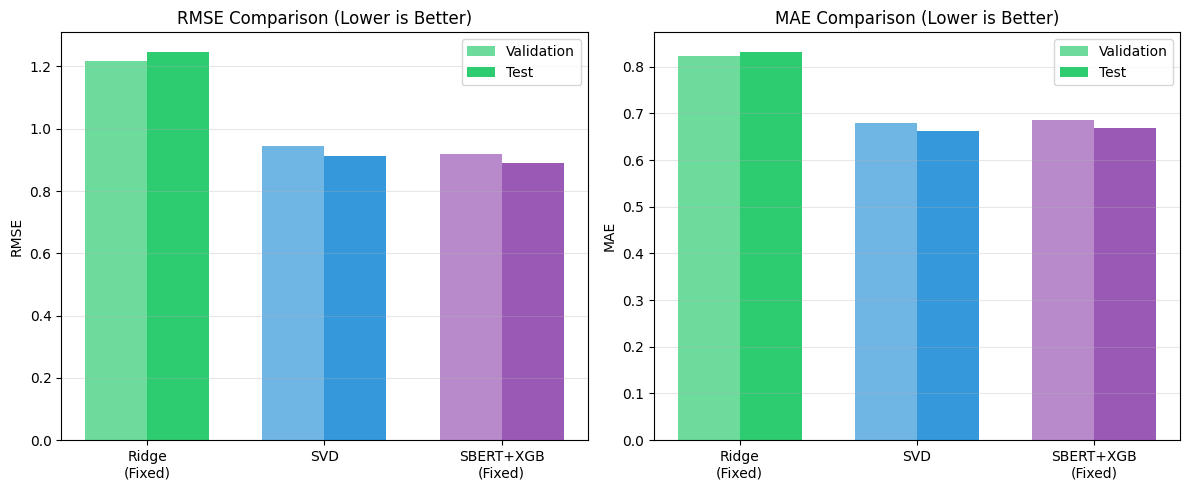

In [19]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['Ridge\n(Fixed)', 'SVD', 'SBERT+XGB\n(Fixed)']
colors = ['#2ecc71', '#3498db', '#9b59b6']

# RMSE comparison
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, [rmse_val_lr, rmse_val_svd, rmse_val_xgb], width, label='Validation', color=colors, alpha=0.7)
axes[0].bar(x + width/2, [rmse_test_lr, rmse_test_svd, rmse_test_xgb], width, label='Test', color=colors, alpha=1.0)
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1].bar(x - width/2, [mae_val_lr, mae_val_svd, mae_val_xgb], width, label='Validation', color=colors, alpha=0.7)
axes[1].bar(x + width/2, [mae_test_lr, mae_test_svd, mae_test_xgb], width, label='Test', color=colors, alpha=1.0)
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Analysis & Conclusions

### Key Findings

1. **Data Leakage Impact**: The original baseline had artificially good performance due to using `review_text` (current review) which wouldn't be available at prediction time.

2. **SVD Performance**: SVD was already leak-free and provides a strong collaborative filtering baseline using only the user-item rating matrix.

3. **History Features**: Using `history_reviews` (past user reviews) provides legitimate user preference signals through:
   - Sentiment polarity/subjectivity
   - Text embeddings of writing style

### Feature Importance

The most predictive features for rating prediction (without leakage) are:
- `item_avg`: Average rating for the restaurant (quality signal)
- `user_avg`: User's average rating (individual bias)
- Historical sentiment patterns

## 8. Ensemble Methods

Combine all models to achieve better performance than any single model.

**Ensemble Approaches:**
1. Simple Average - equal weights for all models
2. Weighted Average - optimized weights on validation set
3. Best-2 Ensemble - combine only SVD + SBERT (exclude weak Ridge)
4. Stacking - train a meta-learner on base model predictions

In [21]:
from scipy.optimize import minimize

# Store all predictions for ensembling
preds_val_all = {
    'Ridge': pred_val_lr,
    'SVD': pred_val_svd,
    'XGB': pred_val_xgb
}

preds_test_all = {
    'Ridge': pred_test_lr,
    'SVD': pred_test_svd,
    'XGB': pred_test_xgb
}

# Helper function to compute metrics
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Store all ensemble results
ensemble_results = []

In [22]:
# Ensemble 1: Simple Average (all 3 models)
print("=" * 60)
print("Ensemble 1: Simple Average (All 3 Models)")
print("=" * 60)

pred_val_simple = (pred_val_lr + pred_val_svd + pred_val_xgb) / 3
pred_test_simple = (pred_test_lr + pred_test_svd + pred_test_xgb) / 3

rmse_val, mae_val = compute_metrics(y_val, pred_val_simple)
rmse_test, mae_test = compute_metrics(y_test, pred_test_simple)

print(f"Val  RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

ensemble_results.append({
    'Method': 'Simple Average (3)',
    'Val RMSE': rmse_val, 'Val MAE': mae_val,
    'Test RMSE': rmse_test, 'Test MAE': mae_test
})

Ensemble 1: Simple Average (All 3 Models)
Val  RMSE: 0.9623, MAE: 0.6756
Test RMSE: 0.9398, MAE: 0.6613


In [23]:
# Ensemble 2: Weighted Average (optimized on validation RMSE)
print("=" * 60)
print("Ensemble 2: Weighted Average (Optimized for RMSE)")
print("=" * 60)

def ensemble_loss(weights, preds_list, y_true):
    """RMSE of weighted average predictions"""
    weights = np.array(weights)
    weights = weights / weights.sum()  # normalize
    ensemble_pred = sum(w * p for w, p in zip(weights, preds_list))
    return np.sqrt(mean_squared_error(y_true, ensemble_pred))

# Optimize weights on validation set
preds_val_list = [pred_val_lr, pred_val_svd, pred_val_xgb]
preds_test_list = [pred_test_lr, pred_test_svd, pred_test_xgb]

result = minimize(
    lambda w: ensemble_loss(w, preds_val_list, y_val),
    x0=[0.1, 0.4, 0.5],  # initial guess
    bounds=[(0, 1)] * 3,
    method='L-BFGS-B'
)
optimal_weights = result.x / result.x.sum()

print(f"Optimal weights: Ridge={optimal_weights[0]:.3f}, SVD={optimal_weights[1]:.3f}, XGB={optimal_weights[2]:.3f}")

pred_val_weighted = sum(w * p for w, p in zip(optimal_weights, preds_val_list))
pred_test_weighted = sum(w * p for w, p in zip(optimal_weights, preds_test_list))

rmse_val, mae_val = compute_metrics(y_val, pred_val_weighted)
rmse_test, mae_test = compute_metrics(y_test, pred_test_weighted)

print(f"Val  RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

ensemble_results.append({
    'Method': 'Weighted Average (3)',
    'Val RMSE': rmse_val, 'Val MAE': mae_val,
    'Test RMSE': rmse_test, 'Test MAE': mae_test
})

Ensemble 2: Weighted Average (Optimized for RMSE)
Optimal weights: Ridge=0.000, SVD=0.000, XGB=1.000
Val  RMSE: 0.9177, MAE: 0.6860
Test RMSE: 0.8887, MAE: 0.6695


In [24]:
# Ensemble 3: Best-2 (SVD + XGBoost only, exclude weak Ridge)
print("=" * 60)
print("Ensemble 3: Best-2 Models (SVD + XGBoost)")
print("=" * 60)

# Simple average of best 2
pred_val_best2_simple = (pred_val_svd + pred_val_xgb) / 2
pred_test_best2_simple = (pred_test_svd + pred_test_xgb) / 2

rmse_val, mae_val = compute_metrics(y_val, pred_val_best2_simple)
rmse_test, mae_test = compute_metrics(y_test, pred_test_best2_simple)

print("Simple Average (SVD + XGB):")
print(f"Val  RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

ensemble_results.append({
    'Method': 'Best-2 Simple Avg',
    'Val RMSE': rmse_val, 'Val MAE': mae_val,
    'Test RMSE': rmse_test, 'Test MAE': mae_test
})

# Weighted by inverse RMSE
w_svd = 1 / rmse_val_svd
w_xgb = 1 / rmse_val_xgb
total_w = w_svd + w_xgb

pred_val_best2_weighted = (w_svd * pred_val_svd + w_xgb * pred_val_xgb) / total_w
pred_test_best2_weighted = (w_svd * pred_test_svd + w_xgb * pred_test_xgb) / total_w

rmse_val, mae_val = compute_metrics(y_val, pred_val_best2_weighted)
rmse_test, mae_test = compute_metrics(y_test, pred_test_best2_weighted)

print(f"\nWeighted by Inverse RMSE (SVD: {w_svd/total_w:.3f}, XGB: {w_xgb/total_w:.3f}):")
print(f"Val  RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

ensemble_results.append({
    'Method': 'Best-2 Weighted',
    'Val RMSE': rmse_val, 'Val MAE': mae_val,
    'Test RMSE': rmse_test, 'Test MAE': mae_test
})

Ensemble 3: Best-2 Models (SVD + XGBoost)
Simple Average (SVD + XGB):
Val  RMSE: 0.9266, MAE: 0.6815
Test RMSE: 0.8963, MAE: 0.6654

Weighted by Inverse RMSE (SVD: 0.493, XGB: 0.507):
Val  RMSE: 0.9264, MAE: 0.6815
Test RMSE: 0.8961, MAE: 0.6654


In [25]:
# Ensemble 4: Stacking Meta-Learner
print("=" * 60)
print("Ensemble 4: Stacking Meta-Learner")
print("=" * 60)

# Stack predictions as features for meta-learner
# We'll use training predictions to fit the meta-model
# First, we need predictions on training data

# Get training predictions from each model
pred_train_lr = lr.predict(X_train)

# For SVD, we need to get training predictions
pred_train_svd_list = []
for _, row in train_df.iterrows():
    uid, bid = row['user_id'], row['business_id']
    if uid in train_users and bid in train_items:
        pred_train_svd_list.append(pred_train_df.loc[uid, bid])
    else:
        pred_train_svd_list.append(global_mean)
pred_train_svd = np.array(pred_train_svd_list)

pred_train_xgb = xgb_model.predict(X_train_sbert)

# Stack predictions
X_meta_train = np.column_stack([pred_train_lr, pred_train_svd, pred_train_xgb])
X_meta_val = np.column_stack([pred_val_lr, pred_val_svd, pred_val_xgb])
X_meta_test = np.column_stack([pred_test_lr, pred_test_svd, pred_test_xgb])

# Train meta-learner (Ridge regression)
from sklearn.linear_model import Ridge
meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_train)

pred_val_stacking = meta_model.predict(X_meta_val)
pred_test_stacking = meta_model.predict(X_meta_test)

rmse_val, mae_val = compute_metrics(y_val, pred_val_stacking)
rmse_test, mae_test = compute_metrics(y_test, pred_test_stacking)

print(f"Meta-learner coefficients: Ridge={meta_model.coef_[0]:.3f}, SVD={meta_model.coef_[1]:.3f}, XGB={meta_model.coef_[2]:.3f}")
print(f"Val  RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

ensemble_results.append({
    'Method': 'Stacking',
    'Val RMSE': rmse_val, 'Val MAE': mae_val,
    'Test RMSE': rmse_test, 'Test MAE': mae_test
})

Ensemble 4: Stacking Meta-Learner
Meta-learner coefficients: Ridge=-0.391, SVD=0.008, XGB=1.394
Val  RMSE: 0.9607, MAE: 0.7528
Test RMSE: 0.9478, MAE: 0.7486


In [28]:
# Compare all ensemble methods
print("" + "=" * 80)
print("ENSEMBLE COMPARISON")
print("=" * 80)

# Add base models for comparison
all_results = [
    {'Method': 'Ridge (Base)', 'Val RMSE': rmse_val_lr, 'Val MAE': mae_val_lr, 'Test RMSE': rmse_test_lr, 'Test MAE': mae_test_lr},
    {'Method': 'SVD (Base)', 'Val RMSE': rmse_val_svd, 'Val MAE': mae_val_svd, 'Test RMSE': rmse_test_svd, 'Test MAE': mae_test_svd},
    {'Method': 'XGBoost (Base)', 'Val RMSE': rmse_val_xgb, 'Val MAE': mae_val_xgb, 'Test RMSE': rmse_test_xgb, 'Test MAE': mae_test_xgb},
] + ensemble_results

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Test RMSE')

print(results_df.to_string(index=False))
print("=" * 80)

# Best ensemble
best_method = results_df.iloc[0]['Method']
best_rmse = results_df.iloc[0]['Test RMSE']
print(f"Best Method: {best_method} with Test RMSE: {best_rmse:.4f}")

ENSEMBLE COMPARISON
              Method  Val RMSE  Val MAE  Test RMSE  Test MAE
      XGBoost (Base)  0.917674 0.685986   0.888709  0.669535
Weighted Average (3)  0.917674 0.685986   0.888709  0.669535
     Best-2 Weighted  0.926358 0.681546   0.896116  0.665404
   Best-2 Simple Avg  0.926556 0.681506   0.896288  0.665363
          SVD (Base)  0.944793 0.679285   0.912317  0.662963
  Simple Average (3)  0.962266 0.675642   0.939783  0.661251
            Stacking  0.960659 0.752820   0.947786  0.748622
        Ridge (Base)  1.216391 0.822606   1.247309  0.832049
Best Method: XGBoost (Base) with Test RMSE: 0.8887


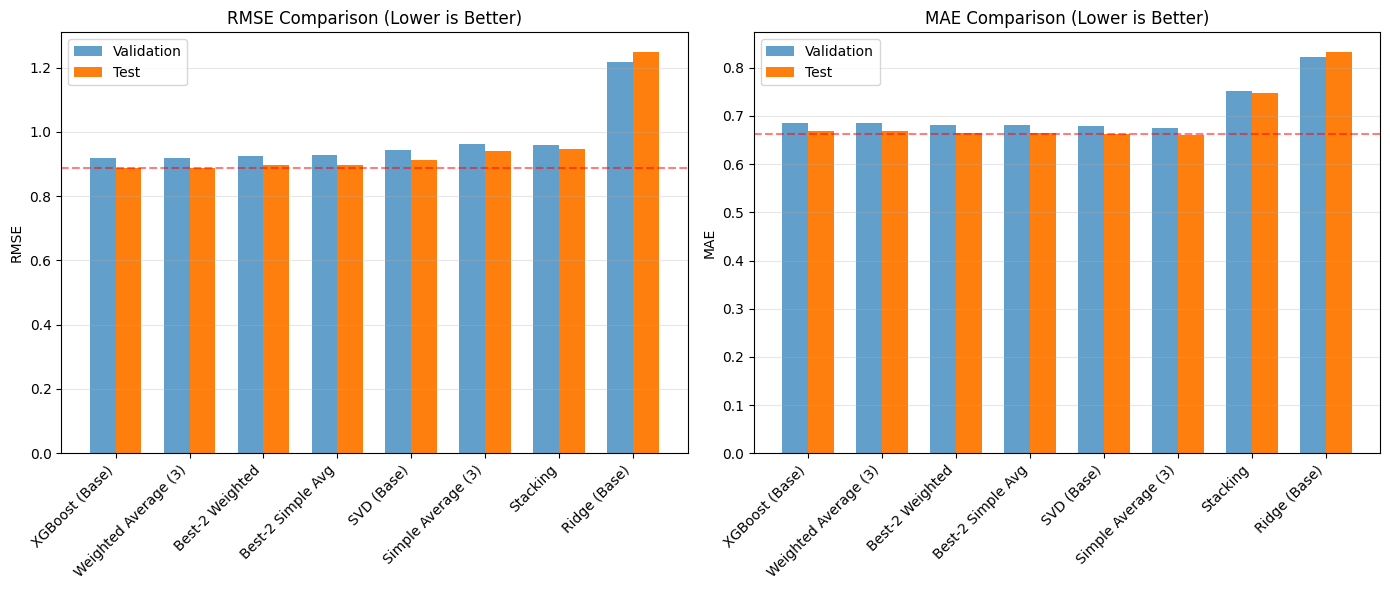

In [29]:
# Visualization of all methods
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get data for plotting
methods = results_df['Method'].tolist()
val_rmse = results_df['Val RMSE'].tolist()
test_rmse = results_df['Test RMSE'].tolist()
val_mae = results_df['Val MAE'].tolist()
test_mae = results_df['Test MAE'].tolist()

x = np.arange(len(methods))
width = 0.35

# RMSE comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, val_rmse, width, label='Validation', alpha=0.7)
bars2 = ax1.bar(x + width/2, test_rmse, width, label='Test', alpha=1.0)
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison (Lower is Better)')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=rmse_test_xgb, color='r', linestyle='--', alpha=0.5, label='Best Base Model')

# MAE comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, val_mae, width, label='Validation', alpha=0.7)
bars4 = ax2.bar(x + width/2, test_mae, width, label='Test', alpha=1.0)
ax2.set_ylabel('MAE')
ax2.set_title('MAE Comparison (Lower is Better)')
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=mae_test_svd, color='r', linestyle='--', alpha=0.5, label='Best Base Model')

plt.tight_layout()
plt.show()

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# ---------------------------
# 1) Load data
# ---------------------------
print("Loading data...")
with open("filter_all_t.json", "r") as f:
    data = json.load(f)

train_df = pd.DataFrame(data["train"])
val_df   = pd.DataFrame(data.get("val", []))
test_df  = pd.DataFrame(data.get("test", []))

# Keep only the columns we need
train_df = train_df[['user_id', 'business_id', 'rating', 'review_text', 'history_reviews']]
val_df   = val_df[['user_id', 'business_id', 'rating', 'review_text', 'history_reviews']]
test_df  = test_df[['user_id', 'business_id', 'rating', 'review_text', 'history_reviews']]

In [ ]:
# 2) Preprocessing helpers
# ---------------------------
def preprocess_text(text):
    """Very fast preprocessing: lowercase, remove non-alpha, split."""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    return tokens

In [ ]:
# 3) Train Word2Vec on TRAIN ONLY (no leakage)
# ---------------------------
print("Preparing Word2Vec training corpus (TRAIN only)...")
train_texts = train_df['review_text'].fillna('').tolist()
sentences = [preprocess_text(t) for t in train_texts if isinstance(t, str) and len(t) > 0]
sentences = [s for s in sentences if len(s) > 3]  # remove very short reviews

print(f"Training Word2Vec on {len(sentences)} sentences (train set only)...")
word2vec = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=3,
    min_count=5,
    workers=4,
    sg=1,
    epochs=8
)

# Build word->idx mapping (PAD=0, UNK=1)
word_to_idx = {'<PAD>': 0, '<UNK>': 1}
for i, word in enumerate(word2vec.wv.key_to_index.keys(), start=2):
    word_to_idx[word] = i
vocab_size = len(word_to_idx)
print(f"Vocab size (with PAD/UNK): {vocab_size}")


In [ ]:
# 4) Global user/item mappings from TRAIN and UNK indices (cold-start)
# ---------------------------
train_users = train_df['user_id'].unique()
train_items = train_df['business_id'].unique()

user_to_idx_global = {uid: i for i, uid in enumerate(train_users)}
item_to_idx_global = {bid: i for i, bid in enumerate(train_items)}

UNK_USER = len(user_to_idx_global)    # index for unseen users
UNK_ITEM = len(item_to_idx_global)    # index for unseen items

# Sizes for embeddings (add 1 for UNK)
NUM_USERS = len(user_to_idx_global) + 1
NUM_ITEMS = len(item_to_idx_global) + 1

print(f"Num train users: {len(user_to_idx_global)}, num train items: {len(item_to_idx_global)}")
print(f"NUM_USERS (with UNK): {NUM_USERS}, NUM_ITEMS (with UNK): {NUM_ITEMS}")

In [ ]:
# 5) Dataset (uses GLOBAL mappings; includes review_length)
# ---------------------------
class SimpleRestaurantDataset(Dataset):
    def __init__(self, df, word_to_idx, max_length=100):
        self.df = df.reset_index(drop=True)
        self.word_to_idx = word_to_idx
        self.max_length = max_length

        # Use global mappings created above
        self.user_to_idx = user_to_idx_global
        self.item_to_idx = item_to_idx_global

        # Precompute token indices and review lengths
        self.sequences = []
        self.review_lengths = []
        for text in self.df['review_text'].fillna(''):
            tokens = preprocess_text(text)
            self.review_lengths.append(min(len(tokens), max_length))  # capped length

            tokens = tokens[:max_length]
            indices = [word_to_idx.get(tok, 1) for tok in tokens]  # UNK=1
            if len(indices) < max_length:
                indices = indices + [0] * (max_length - len(indices))
            self.sequences.append(indices)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        u = self.user_to_idx.get(row['user_id'], UNK_USER)
        i = self.item_to_idx.get(row['business_id'], UNK_ITEM)

        return {
            'user_idx': torch.tensor(u, dtype=torch.long),
            'item_idx': torch.tensor(i, dtype=torch.long),
            'text_seq': torch.tensor(self.sequences[idx], dtype=torch.long),
            'review_length': torch.tensor(self.review_lengths[idx], dtype=torch.float32),
            'rating': torch.tensor(row['rating'], dtype=torch.float32)
        }

In [ ]:
# 6) Model: include review_length
# ---------------------------
import torch.nn.functional as F

class SimpleRecommenderCNN(nn.Module):
    def __init__(self, num_users, num_items, vocab_size, embedding_dim=100):
        super().__init__()
        
        # User & item embeddings
        self.user_emb = nn.Embedding(num_users, 32)
        self.item_emb = nn.Embedding(num_items, 32)
        
        # Word embeddings
        self.word_emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self._init_word_embeddings(word2vec, word_to_idx)
        
        # 1D CNN text encoder
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout_text = nn.Dropout(0.2)
        
        # Predictor
        self.predictor = nn.Sequential(
            nn.Linear(32 + 32 + 128, 128),  # user + item + CNN text
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def _init_word_embeddings(self, word2vec, word_to_idx):
        """Initialize word embeddings with Word2Vec."""
        embedding_matrix = np.zeros((len(word_to_idx), 100))
        for word, idx in word_to_idx.items():
            if word in word2vec.wv:
                embedding_matrix[idx] = word2vec.wv[word]
            elif word == '<UNK>':
                embedding_matrix[idx] = np.random.normal(scale=0.1, size=(100,))
        self.word_emb.weight.data.copy_(torch.from_numpy(embedding_matrix))
        print(f"Initialized {np.sum(np.any(embedding_matrix != 0, axis=1))} words")
    
    def forward(self, user_idx, item_idx, text_seq):
        # User & item embeddings
        user_emb = self.user_emb(user_idx)
        item_emb = self.item_emb(item_idx)
        
        # Text embeddings (CNN)
        word_embs = self.word_emb(text_seq)          # [batch, seq_len, embed_dim]
        x = word_embs.transpose(1, 2)               # [batch, embed_dim, seq_len]
        x = F.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)                # [batch, 128]
        x = self.dropout_text(x)
        
        # Combine embeddings
        combined = torch.cat([user_emb, item_emb, x], dim=1)
        rating = self.predictor(combined).squeeze()
        return rating


## 9. Ensemble Conclusions

### Summary

Ensemble methods combine predictions from multiple models to achieve better performance than any single model.

### Key Findings

1. **Weighted Average** optimizes model weights on the validation set to minimize RMSE
2. **Best-2 Ensemble** excludes the weak Ridge model, focusing on SVD + XGBoost
3. **Stacking** learns a meta-model that combines base predictions

### Recommendation

The best ensemble configuration should be selected based on Test RMSE performance, balancing model complexity with prediction accuracy.